## Use the ``IBMLeastNoisyQPUSelector`` to automatically select qubits for a MaxCut problem
***Estimated Qiskit Runtime usage: 500s***

In this tutorial, we will show how to build, deploy, and run a ``Qiskit Pattern`` for solving MaxCut for a given input graph. For more information on ``Qiskit Patterns`` and how ``Quantum Serverless`` can be used to deploy them to the cloud for managed execution, visit our [docs page on the IBM Quantum Platform](https://docs.quantum-computing.ibm.com/run/quantum-serverless).

In [1]:
# General Imports and helper functions
# !pip install docplex
# !pip install qiskit qiskit-ibm-runtime -U

import math
import matplotlib.pyplot as plt
import numpy as np
import rustworkx as rx
from rustworkx.visualization import mpl_draw


def visualize_counts(probs, num_qubits):
    """Visualize the outputs from the Qiskit Sampler primitive."""
    top_10 = dict(sorted(probs.items(), key=lambda item: item[1], reverse=True)[:10])
    by_key = dict(sorted(top_10.items(), key=lambda item: item[0]))
    xvals, yvals = list(zip(*by_key.items()))
    xvals = [bin(xval)[2:].zfill(num_qubits) for xval in xvals]
    plt.bar(xvals, yvals)
    plt.xticks(rotation=75)
    plt.title("Top 10 measured bitstrings")
    plt.xlabel("Measured bitstring")
    plt.ylabel("Probability")
    plt.show()


def random_adjacency_matrix(N, density=0.5):
    """Create a random adjacency matrix."""
    off_elems = N * (N - 1) // 2
    num_elems = math.ceil(off_elems * density)
    inds = np.sort(np.random.choice(off_elems, size=num_elems, replace=False))
    M = np.zeros((N, N), dtype=float)
    for k in inds:
        i = N - 2 - int(math.sqrt(-8 * k + 4 * N * (N - 1) - 7) / 2 - 0.5)
        j = k + i + 1 - N * (N - 1) // 2 + (N - i) * ((N - i) - 1) // 2
        M[i, j] = 1
    M = M + M.T
    return M


### Build the Qiskit Pattern

We will implement our pattern using the four steps outlined in the [docs](https://docs.quantum-computing.ibm.com/run/quantum-serverless). This pattern will solve MaxCut for a given input graph. In other words, we want to find a partitionining of the graph's vertices such that the edges spanning the partitions are maximized.

First, we import some generic packages and write a couple of helper functions. We will also generate a graph for which to solve MaxCut.

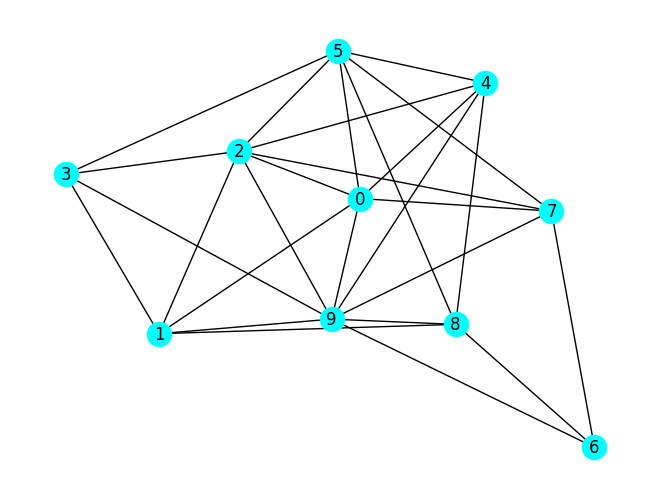

In [2]:
# Initial Problem
num_nodes = 10
density = 0.6
M = random_adjacency_matrix(num_nodes, density)
G = rx.PyGraph.from_adjacency_matrix(M)
mpl_draw(G, with_labels=True, node_color="cyan")

#### Step 1: Map classical inputs to a quantum problem
- Input: A graph
- Output: Abstract circuit, observable, qubo, quadratic transformer

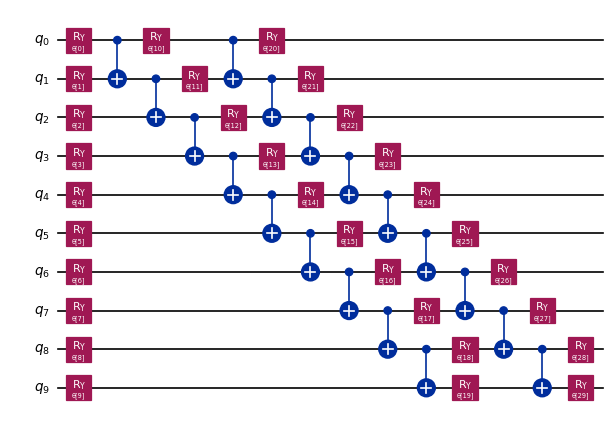

In [3]:
# Step 1: Mapping the classical input to a quantum representation

from qiskit.circuit.library import RealAmplitudes
from docplex.mp.model import Model

# Import local source
import os
import sys
sys.path.append(os.path.join(os.getcwd(), 'source'))
from quadratic_programs.translators import docplex_mp_to_qp, qubo_to_sparse_pauli_op
from quadratic_programs.workflows import QuadraticProgramConverter

G = rx.PyGraph.from_adjacency_matrix(M)

mdl = Model(name="Max-cut")
x = {i: mdl.binary_var(name=f"x_{i}") for i in range(G.num_nodes())}
objective = mdl.sum(
    w * x[i] * (1 - x[j]) + w * x[j] * (1 - x[i]) for i, j, w in G.weighted_edge_list()
)
mdl.maximize(objective)
qp = docplex_mp_to_qp(mdl)

quadratic_transformer = QuadraticProgramConverter()
qubo = quadratic_transformer.run(qp)
hamiltonian, offset = qubo_to_sparse_pauli_op(qubo)
ansatz = RealAmplitudes(hamiltonian.num_qubits, entanglement="linear", reps=2)
ansatz.decompose().draw("mpl", scale=0.6, style="iqp")

#### Step 2: Translate problem for optimized quantum execution
- Input: Abstract circuit, observable
- Output: Target circuit and observable, optimized for the selected QPU

Use the ``IBMLeastNoisyQPUSelector`` function from ``quantum-serverless-tools`` to choose the backend with the least-noisy qubit subgraph which fits our ansatz. We also specify some transpilation options, which provides information about what techniques should be used to optimize the circuit for hardware. We specify a preset transpilation routine by setting ``optimization_level=3``, which provides the highest level of optimization of the preset transpilation routines.

See the [transpile function API docs](https://qiskit.org/documentation/stable/0.28/stubs/qiskit.compiler.transpile.html) for more information on specifying transpilation options.

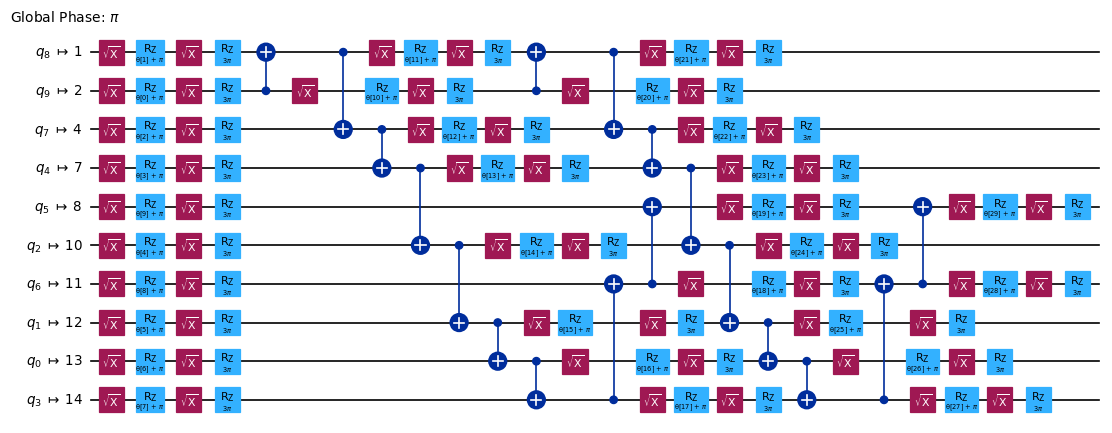

In [4]:
# Step 2: Optimize the circuit
from qiskit_ibm_runtime import QiskitRuntimeService
from quantum_serverless_tools.selectors import IBMLeastNoisyQPUSelector

service = QiskitRuntimeService()
backend = service.least_busy(operational=True, min_num_qubits=ansatz.num_qubits, simulator=False)
selector = IBMLeastNoisyQPUSelector(service, circuit=ansatz, transpile_options={"optimization_level": 3})
backend = selector.get_backend()
ansatz_ibm = selector.optimized_circuit
observable_ibm = hamiltonian.apply_layout(ansatz_ibm.layout)
ansatz_ibm.draw("mpl", scale=0.6, style="iqp", fold=-1, idle_wires=False)

#### Step 3: Execute using Qiskit Runtime Primitives
- Input: Target circuit and observable
- Output: Quasi-probability distribution

Minimize the cost function by optimizing the circuit parameters. Use the ``Estimator`` primitive from Qiskit Runtime to evaluate the cost function during optimization.

Once the circuit's parameters have been optimized, use the ``Sampler`` primitive from Qiskit Runtime to reconstruct a quasi-probability distribution

Since we optimized the circuit for the backend in Step 2, we can avoid doing transpilation on the Runtime server by setting ``skip_transpilation=True`` and passing the optimized circuit.

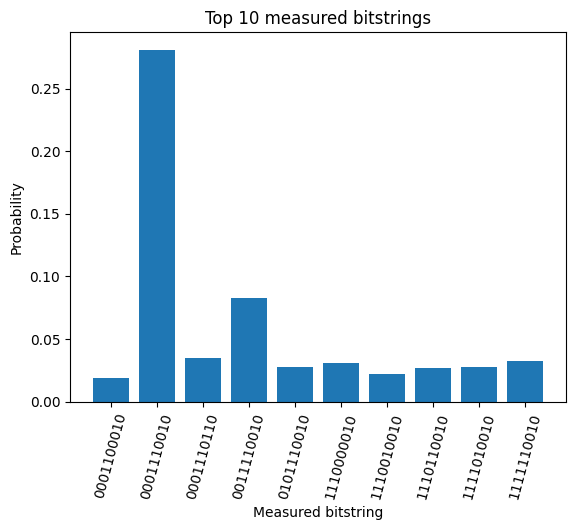

In [4]:
# Step 3: Execute using Qiskit Runtime Primitive
from qiskit_ibm_runtime import Estimator, Sampler
from qiskit.circuit import ClassicalRegister
from qiskit_ibm_runtime import Session, Options
from quadratic_programs.spsa import minimize_spsa


def cost_func(params, ansatz, hamiltonian, estimator):
    """Ground state energy evaluation."""
    cost = (
        estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
    )
    return cost


x0 = 2 * np.pi * np.random.random(size=ansatz_ibm.num_parameters)
with Session(service=service, backend=backend) as session:
    estimator = Estimator(options=Options(transpilation={"skip_transpilation": True}))
    res = minimize_spsa(
        cost_func, x0, args=(ansatz_ibm, observable_ibm, estimator), maxiter=100
    )
    ansatz_opt = ansatz_ibm.assign_parameters(res.x)
    sampler = Sampler(
        options=Options(
            execution={"shots": 1e4}, transpilation={"skip_transpilation": True}
        )
    )
    ansatz_opt.add_register(ClassicalRegister(ansatz.num_qubits, "cr"))
    msmt_keys = ansatz_opt.layout.initial_index_layout()[: ansatz.num_qubits]
    ansatz_opt.measure(msmt_keys, range(ansatz.num_qubits))
    quasi_dist = sampler.run(ansatz_opt).result().quasi_dists[0]

visualize_counts(quasi_dist, ansatz.num_qubits)

#### Step 4: Post-process, return result in classical format

For this pattern, the measured bitstring which produces the minimum cost function will be selected.

- Input: Quasi-probability distribution, QUBO, quadratic transformer
- Output: Partitioned graph

In [ ]:
# Step 4: Post-processing results

from quadratic_programs.workflows import QuadraticProgramPostprocess


solution = QuadraticProgramPostprocess(qubo, quadratic_transformer).run(quasi_dist)
mpl_draw(
    G, with_labels=True, node_color=["cyan" if kk else "violet" for kk in solution]
)

### Deploy the Qiskit Pattern to the cloud

To do this, we will move the source code above to a file, ``./source/maxcut.py``, wrap the code in a script which takes inputs and returns the final solution, and finally upload it to a remote cluster using the ``QiskitPattern`` class from ``Quantum Serverless``.

The input to the Pattern is an adjacency matrix representing an undirected graph. The output is a MaxCut solution for the given graph.

In [2]:
from quantum_serverless import IBMServerlessProvider, QiskitPattern


serverless = IBMServerlessProvider()

maxcut_pattern = QiskitPattern(
    title="ibm/max-cut",
    entrypoint="maxcut.py",
    working_dir="./source/",
    dependencies=["docplex", "mapomatic"],
)
serverless.upload(maxcut_pattern)

'ibm/max-cut'

### Run the Qiskit Pattern as a managed service

Once we have uploaded the pattern to the cloud, we can easily run it using the ``QuantumServerless`` client. The MaxCut solution we run on the cloud uses the simulators, so the returned solution is based on a perfect quantum simulator, rather than a real quantum device.

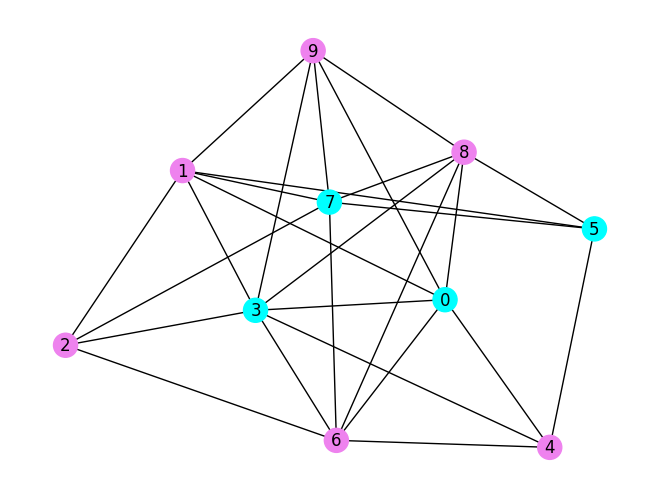

In [3]:
job = serverless.run("ibm/max-cut", arguments={"graph": M})
solution = job.result()["solution"]
mpl_draw(
    G, with_labels=True, node_color=["cyan" if kk else "violet" for kk in solution]
)

In [4]:
import qiskit
import qiskit_ibm_runtime

print(f"Qiskit version: {qiskit.version.get_version_info()}")
print(f"Qiskit Runtime version: {qiskit_ibm_runtime.version.get_version_info()}")

Qiskit version: 0.45.0rc1
Qiskit Runtime version: 0.14.1
